# Interpretability Classification Notebook
This notebook provides the baseline code for reproducing the toy precipitation **classifier** results in our paper "*Towards Interpretable Machine Learning in the Geosciences*". As research reproducibility is a critically important aspect of this type of work, this notebook allows for quick testing, adapatation, and reuse of the code without needing to download your own data or set up a virtual environment.

We demonstrates the workflow for splitting a dataset, training a toy neural network, training a sparse autoencoder on the neural network activations, and plotting the results for interpretation.

Due to the stochastic nature of training these models, combined with slightly different software versions of TensorFlow, there can be a +/- 1% difference in the results here compared to those shown in our paper (however, the underlying features remain consistent).

The full notebook takes around **8 minutes** to run on a T4 GPU.

Finally, this work is heavily inspired by Nelson Elhage and Chris Olah's work on Toy Models of Superposition (https://transformer-circuits.pub/2022/toy_model/index.html).

If you have any questions, please reach out to Fraser King (kingfr@umich.edu).

In [1]:
### Custom PIP installations for Colab

!pip install --quiet umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00


In [2]:
### Set up ENV variables and seeding for reproducibility

SEED = 0

import os
os.environ["PYTHONHASHSEED"] = "0"
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import gc
import random
import numpy as np
import tensorflow as tf
tf.config.experimental.enable_op_determinism()
print(tf.__version__)

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2.17.1


In [3]:
### Remaining package imports

import umap
import math
import warnings
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.layers import Dense, Input
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr
from keras import regularizers


### Global settings and helper functions

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 26})

def reset_keras_backend():
    tf.keras.backend.clear_session()
    gc.collect()

In [4]:
### Global variable declarations

# - n0 is particle size distribution intercept
# - Fs is the particle Fall speed
# - Dm is mass-weighted mean diameter
# - Temperature is 2-meter air temperature
# - Relative HUmidity is surface relative humidity
# - precip_class is the precipitation type (intensity and phase)
predictors = ['n0', 'Fs', 'Dm', 'Temperature', 'Relative Humidity']
response = 'precip_class'
STATE = 42
colors = ['#3cb44b', '#4363d8','#bfef45','#42d4f4','#911eb4', \
             '#ffe119','#e6194B', '#f032e6','#f58231']


# MLP Hyperparameters

LOSS_FUNC = 'categorical_crossentropy'
ACTIVATION = 'relu'
BATCH_SIZE = 32
OPTIMIZER = 'ADAM'
N_HIDDEN = 6
N_EPOCHS = 32
N_INPUT = len(predictors)
LR = 0.0005


# SAE Hyperparameters

SAE_LR=0.001
SAE_LOSS='mse'
SAE_ENC_ACTIVATION='relu'
SAE_BATCH = 8
SAE_N_EPOCHS = 75
L1 = 0.01

In [5]:
### Gdown to download example data to session
### (file will be deleted when session is stopped)

file_id = "1SDGE3G82Q0nn1tSBMhzcwxrELLW2db5L"
output_file = "data_class.parquet"
download_link = f"https://drive.google.com/uc?id={file_id}"

if not os.path.exists(output_file):
    print(f"{output_file} not found. Downloading from Google Drive...")
    !gdown --id $file_id -O $output_file
else:
    print(f"{output_file} already exists. Skipping download.")

data_class.parquet not found. Downloading from Google Drive...
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SDGE3G82Q0nn1tSBMhzcwxrELLW2db5L
To: /content/data_class.parquet
100% 1.69M/1.69M [00:00<00:00, 154MB/s]


In [6]:
### Load Parquet data into a dataframe

def load_and_scale(path):
    df = pd.read_parquet(path)
    print("Data loaded!\n")

    # log-scaled variables
    df['n0'] = np.log10(df['n0'])
    df['Dm'] = np.log10(df['Dm'])

    print(f'{len(df)} total rows')
    print(f'{len(df.columns)-1} variables')
    print(f'{len(df)*(len(df.columns)-1)} value combinations')
    return df

df = load_and_scale(output_file)

Data loaded!

51290 total rows
7 variables
359030 value combinations


In [7]:
### Data standardization and splitting process

def get_X_Y_Z(df, predictors, response):
    df_loc = df.copy()

    # Remove ambiguous class case from the data
    df_loc = df_loc[df_loc[response] != 0]
    df_loc[response] = df_loc[response] - 1

    X = df_loc[predictors]
    y = df_loc[response]

    # Data cleaning to remove infinities or nans in the observations
    data = pd.concat([X, y], axis=1)
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_cleaned = data.dropna()
    X_cleaned = data_cleaned[predictors]
    y_cleaned = data_cleaned[response]

    # We apply some custom splitting of the data into 60%/20%/20% for various
    # stages of training the MLP, training the SAE, and testing
    # Note: shuffle is False to mitigate temporal autocorrelation
    X_data, temp_data, y_data, temp_labels, data_indices, temp_indices = train_test_split(
        X_cleaned, y_cleaned, data_cleaned.index, test_size=0.4, shuffle=False, random_state=STATE
    )

    Y_data, Z_data, y_Y, y_Z, indices_Y, indices_Z = train_test_split(
        temp_data, temp_labels, temp_indices, test_size=0.5, shuffle=False, random_state=STATE
    )

    X_data = X_data.to_frame() if isinstance(X_data, pd.Series) else X_data
    Y_data = Y_data.to_frame() if isinstance(Y_data, pd.Series) else Y_data
    Z_data = Z_data.to_frame() if isinstance(Z_data, pd.Series) else Z_data

    # Scale inputs
    scaler = StandardScaler()
    X_data_scaled = scaler.fit_transform(X_data)
    Y_data_scaled = scaler.transform(Y_data)
    Z_data_scaled = scaler.transform(Z_data)

    # Save scaling information for inversions later
    scaling_info = {
        'mean': scaler.mean_.tolist(),
        'scale': scaler.scale_.tolist()
    }

    return (X_data_scaled, Y_data_scaled, Z_data_scaled,
            y_data, y_Y, y_Z,
            data_indices, indices_Y, indices_Z,
            scaler, scaling_info)

In [8]:
### Perform data split

mlp_train_X, sae_train_X, sae_test_X, mlp_train_y, sae_train_y, sae_test_y, \
data_indices, indices_Y, indices_Z, scaler, scaling_info = get_X_Y_Z(df, predictors, response)

print("\nTraining shapes:")
print("X:", mlp_train_X.shape)
print("Y:", sae_train_X.shape)
print("Y:", sae_test_X.shape)

print("\nTesting shapes:")
print("X:", mlp_train_y.shape)
print("Y:", sae_train_y.shape)
print("Z:", sae_test_y.shape)


Training shapes:
X: (27825, 5)
Y: (9275, 5)
Y: (9276, 5)

Testing shapes:
X: (27825,)
Y: (9275,)
Z: (9276,)


In [9]:
### MLP Classifier model construction and training

mlp_X_train, mlp_X_val, mlp_y_train, mlp_y_val = train_test_split(
    mlp_train_X, mlp_train_y, test_size=0.2, random_state=STATE, shuffle=False
)

# Convert to class matrix
num_classes = len(np.unique(mlp_train_y))
if mlp_y_train.ndim < 2:
    mlp_y_train_cat = to_categorical(mlp_y_train, num_classes=num_classes)
    mlp_y_val_cat = to_categorical(mlp_y_val, num_classes=num_classes)
else:
    mlp_y_train_cat = mlp_y_train
    mlp_y_val_cat = mlp_y_val

# Construct model (nothing fancy here)
model = Sequential()
input_shape = mlp_X_train.shape[1]
model.add(Dense(N_HIDDEN, activation=ACTIVATION, input_shape=(input_shape,)))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer,
              loss=LOSS_FUNC,
              metrics=['accuracy'])

# Fit the model to our training data
history = model.fit(mlp_X_train, mlp_y_train_cat,
                    validation_data=(mlp_X_val, mlp_y_val_cat),
                    epochs=N_EPOCHS,
                    batch_size=BATCH_SIZE)

if sae_test_y.ndim < 2:
    sae_test_y_cat = to_categorical(sae_test_y, num_classes=num_classes)
else:
    sae_test_y_cat = sae_test_y

# Fidelity metrics
test_loss_mlp, test_accuracy_mlp = model.evaluate(sae_test_X, sae_test_y_cat)
y_test_pred = model.predict(sae_test_X)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

print(f"\nTest Accuracy: {test_accuracy_mlp:.4f}")
print("\nClassification Report:\n", classification_report(sae_test_y, y_test_pred_classes))
print("\nConfusion Mat/rix:\n", confusion_matrix(sae_test_y, y_test_pred_classes))

# I like to show the model summary to confirm the structure
model.summary()

Epoch 1/32
696/696 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2080 - loss: 1.9954 - val_accuracy: 0.6406 - val_loss: 1.1271
Epoch 2/32
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7047 - loss: 1.0285 - val_accuracy: 0.8505 - val_loss: 0.6355
Epoch 3/32
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8476 - loss: 0.6159 - val_accuracy: 0.9202 - val_loss: 0.4450
Epoch 4/32
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8972 - loss: 0.4573 - val_accuracy: 0.9387 - val_loss: 0.3468
Epoch 5/32
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9189 - loss: 0.3683 - val_accuracy: 0.9517 - val_loss: 0.2868
Epoch 6/32
696/696 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9339 - loss: 0.3087 - val_accuracy: 0.9569 - val_loss: 0.2462
Epoch 7/32
696/696 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9435 - loss: 0.2651 - val_accuracy: 0.9615 - val_loss: 0.2167
Epoch 8/32
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9494 - loss: 0.2321 - val_accuracy: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 299 (1.17 KB)

 Trainable params: 99 (396.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 200 (804.00 B)

In [10]:
### SAE model cosntruction and training

# Reset the TF backend
reset_keras_backend()
gc.collect()

# Retrieve MLP activations for training the SAE
activation_model = Model(inputs=model.layers[0].input, outputs=model.layers[0].output)
sae_train_activations = activation_model.predict(sae_train_X)

# Model construction
input_dim = sae_train_activations.shape[1]
encoding_dim = input_dim * 2
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation=SAE_ENC_ACTIVATION,
                activity_regularizer=regularizers.l1(L1))(input_layer) # L1
decoded = Dense(input_dim, activation='linear')(encoded)
optimizer = tf.keras.optimizers.Adam(learning_rate=SAE_LR)
sae_model = Model(inputs=input_layer, outputs=decoded)
sae_model.compile(optimizer=optimizer, loss=SAE_LOSS)

# Fit the SAE using the MLP hidden layer activations
sae_history = sae_model.fit(sae_train_activations, sae_train_activations,
                            epochs=SAE_N_EPOCHS,
                            batch_size=SAE_BATCH,
                            shuffle=False)
sae_test_activations = activation_model.predict(sae_test_X)

# Save the encoder model for later
encoder_model = Model(inputs=sae_model.input, outputs=sae_model.layers[1].output)

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.7067
Epoch 2/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.4795
Epoch 3/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0474
Epoch 4/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7879
Epoch 5/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6232
Epoch 6/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5154
Epoch 7/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4423
Epoch 8/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3885
Epoch 9/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3489
Epoch 10/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3185
Epoch 11/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.2949
Epoch 12/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.2749
Epoch 13/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.2582
Epoch 14/75
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - l

Unscaled Input: [[2.83514901e+00 5.63061842e+00 1.55966426e-01 2.76261111e+02
  9.70000000e+01]]


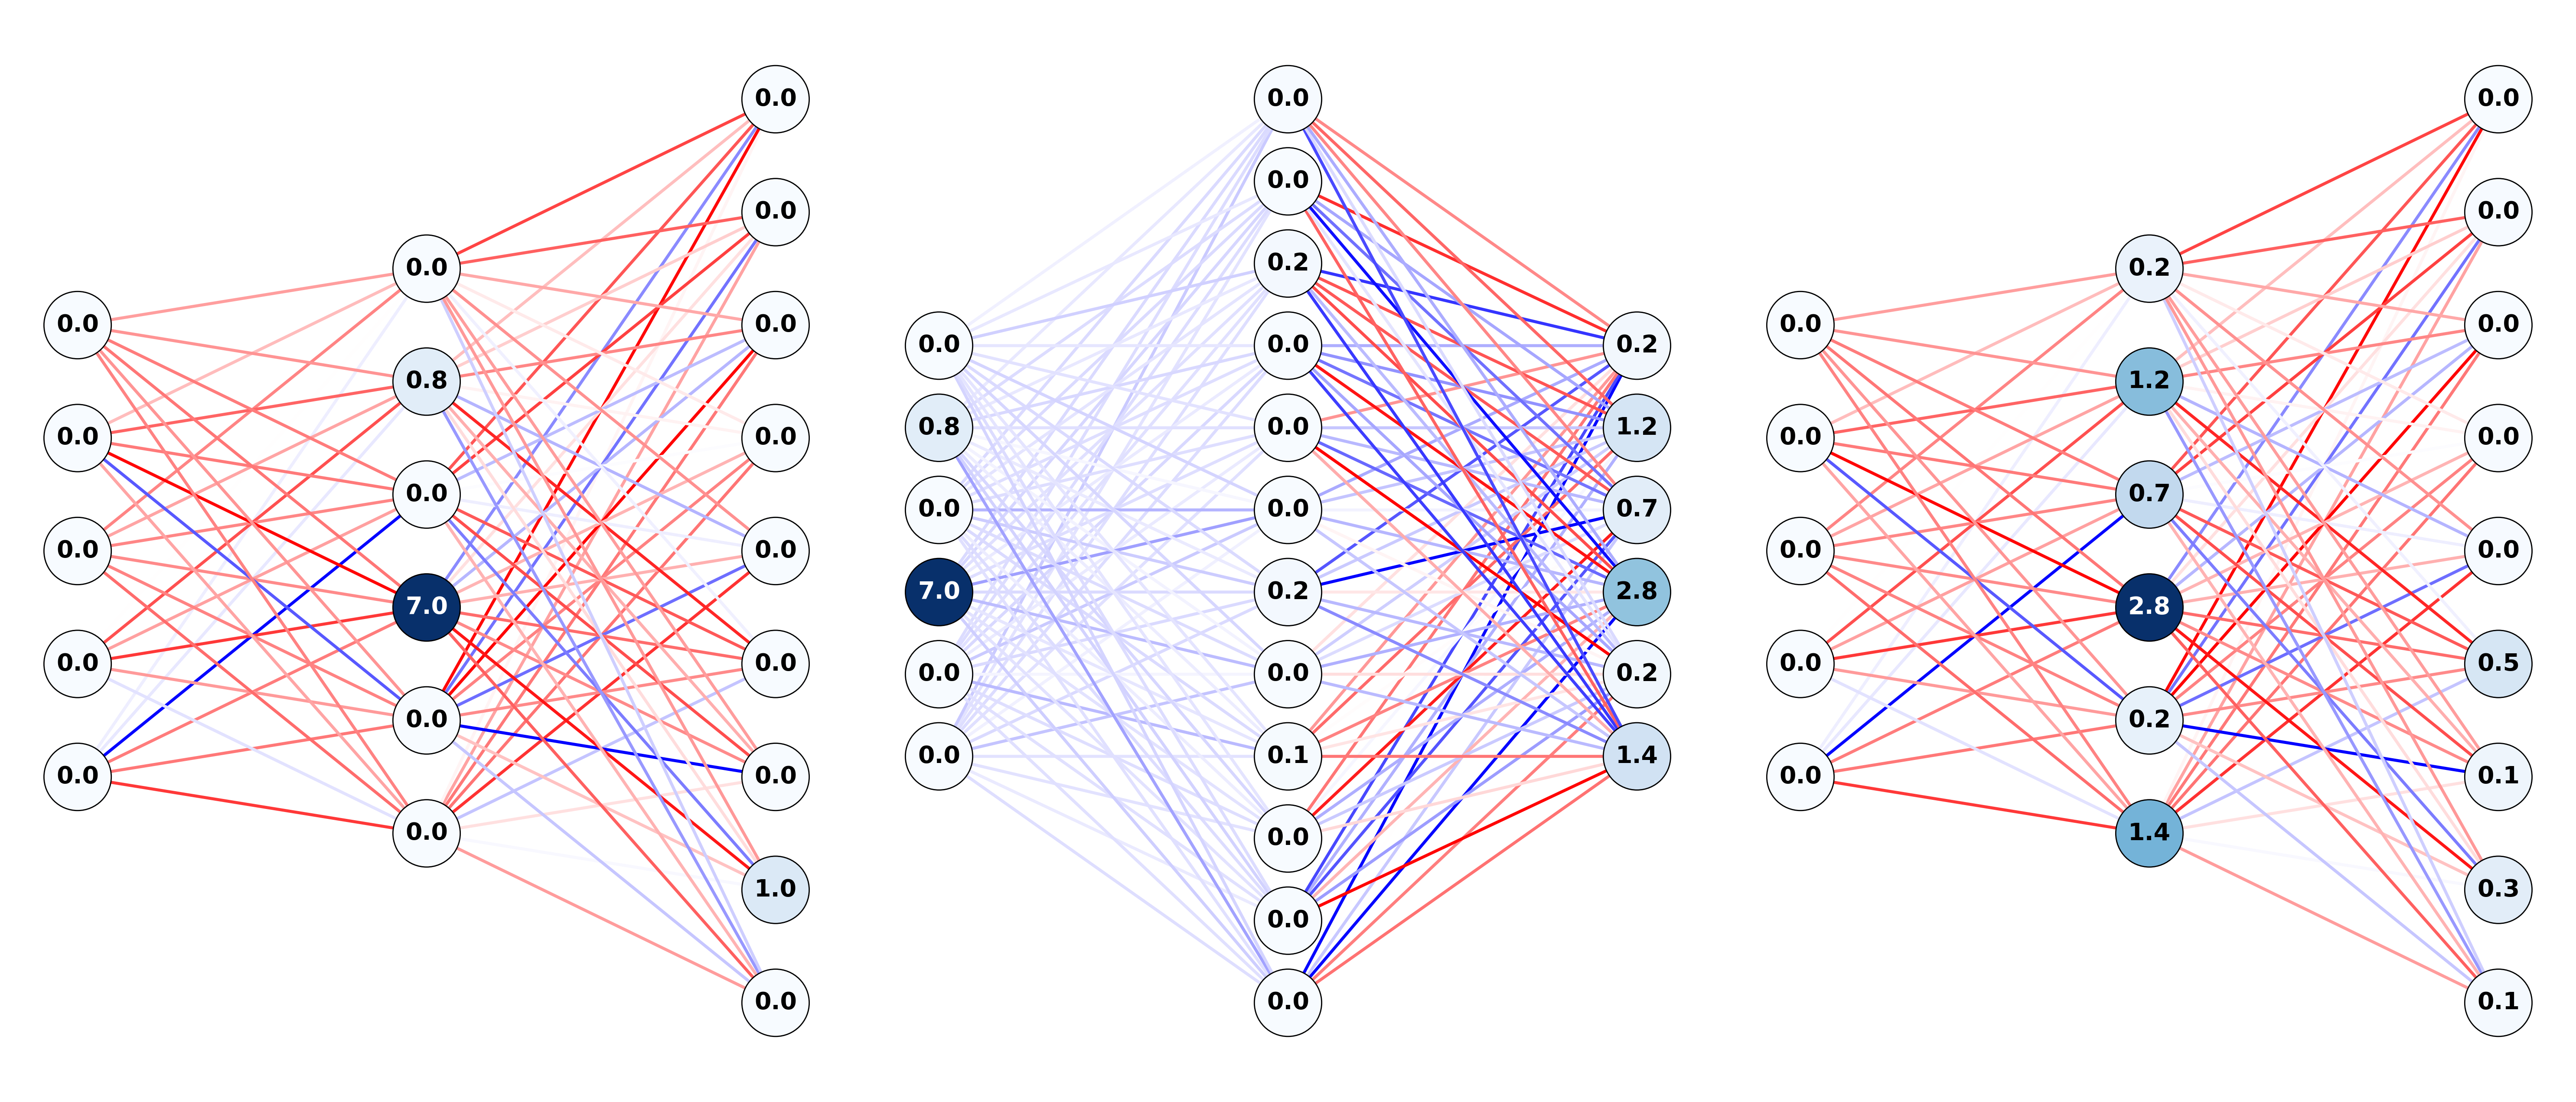

Unscaled Input: [[2.71889684e+00 6.69282292e-01 2.27809163e-01 2.64150000e+02
  9.10000000e+01]]


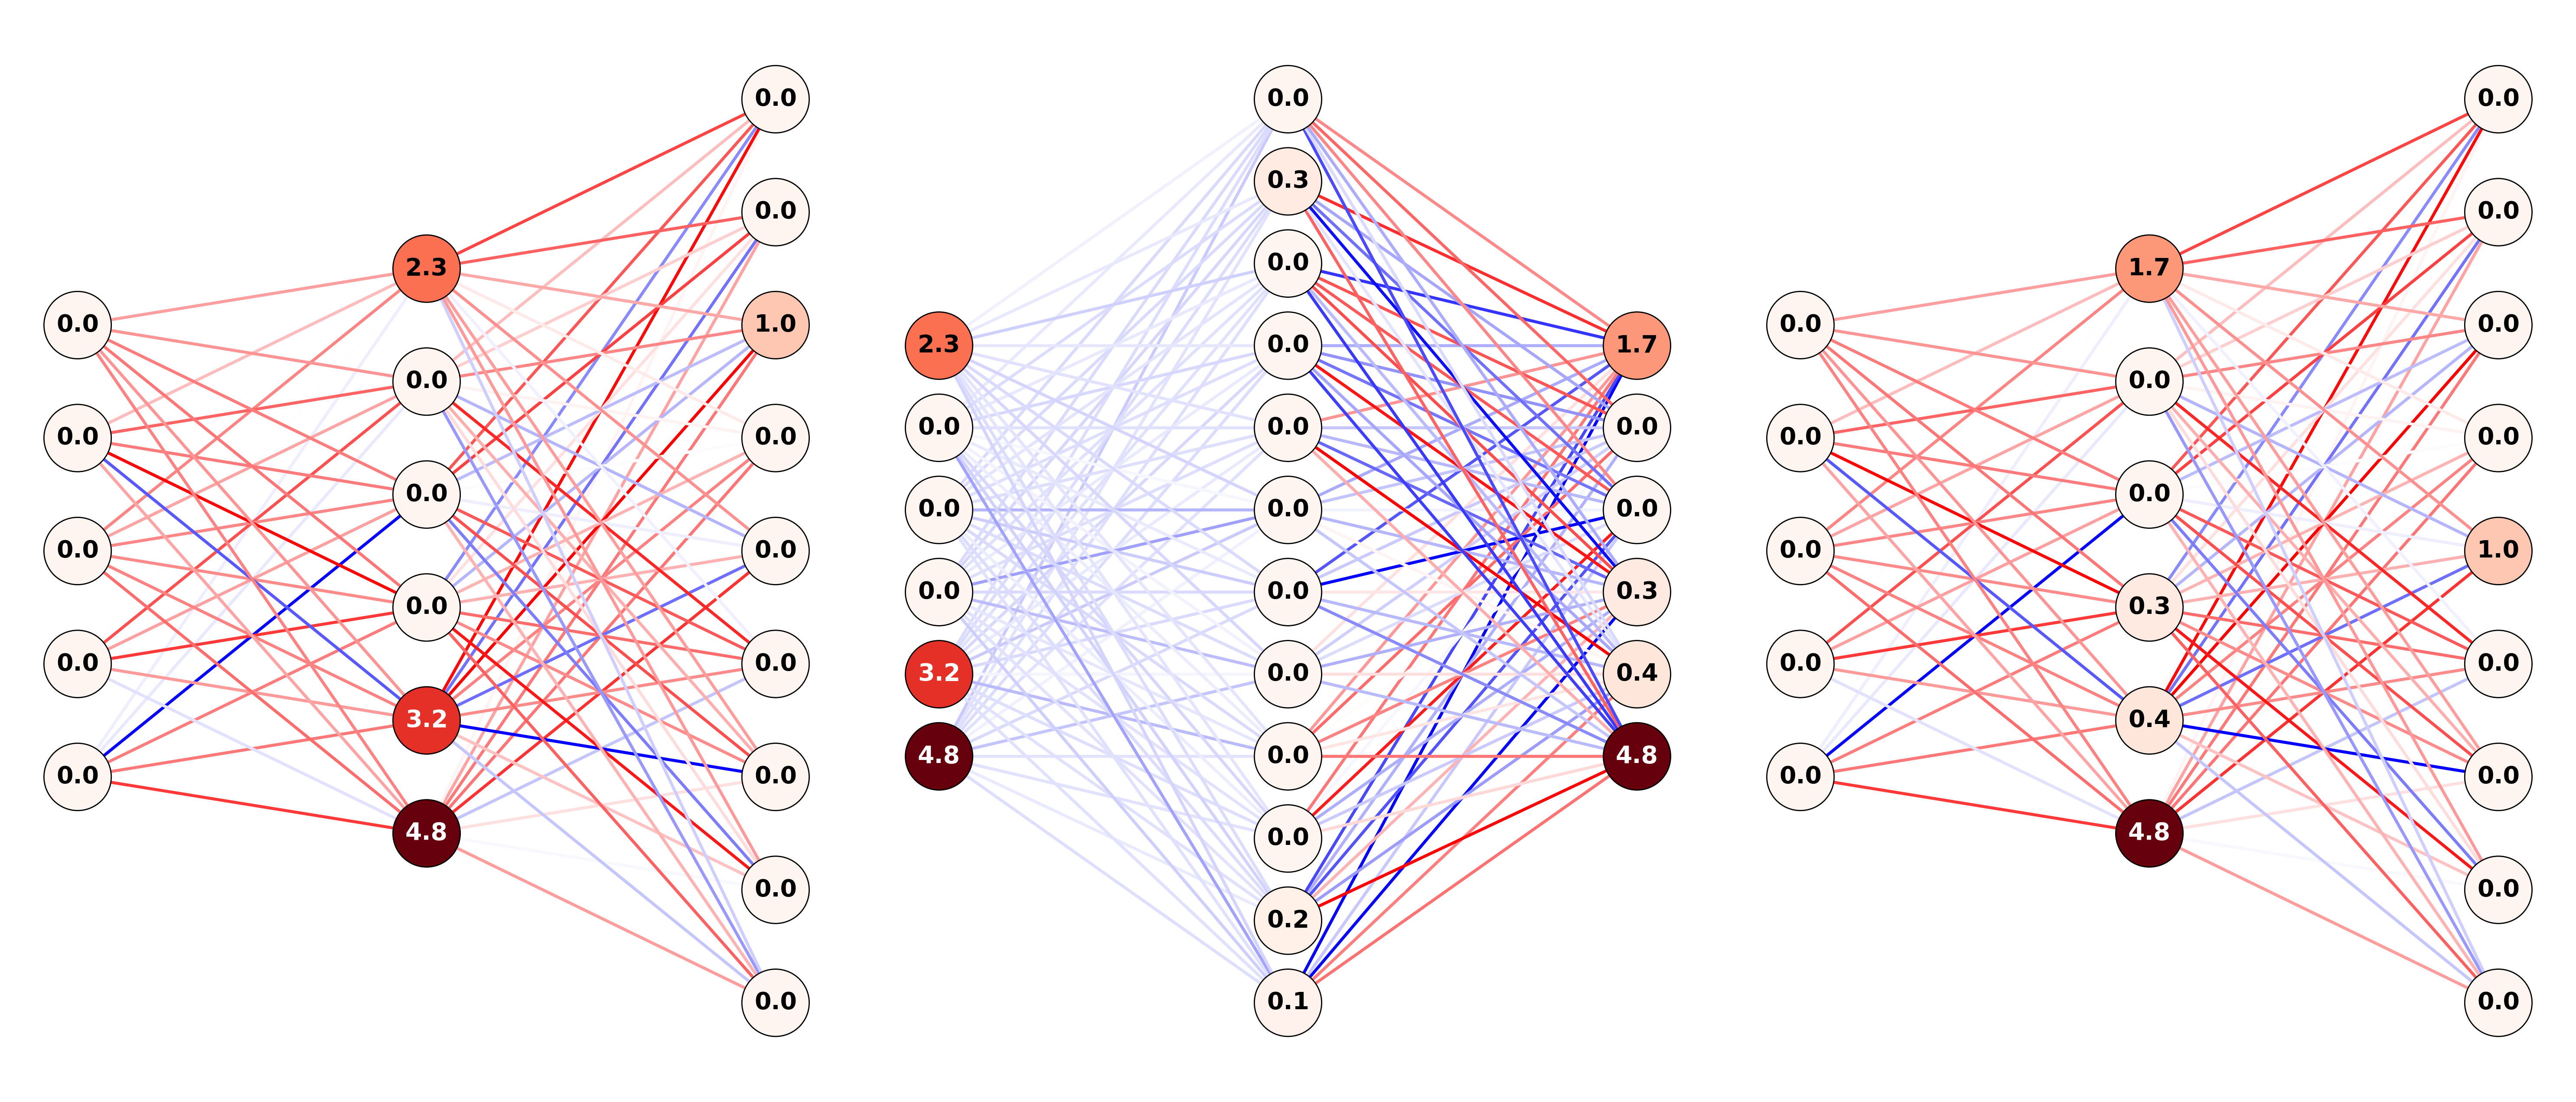

In [11]:
### Model flow diagram visualization (this uses networkx to render the NNs)
### https://networkx.org/

# Helper functions for plotting
def normalize(values):
    if len(values) == 0:
        return values
    vmin, vmax = np.min(values), np.max(values)
    eps = 1e-8
    denom = (vmax - vmin) + eps
    return (values - vmin) / denom

def log_normalize(values):
    if len(values) == 0:
        return values
    transformed = []
    for v in values:
        sign_v = 1 if v >= 0 else -1
        val_log = np.log1p(abs(v))
        transformed.append(sign_v * val_log)
    transformed = np.array(transformed, dtype=np.float32)
    tmin, tmax = transformed.min(), transformed.max()
    eps = 1e-8
    denom = (tmax - tmin) + eps
    out = (transformed - tmin) / denom
    return out


# Build a directed graph with:
# - Nodes for each neuron, labeled by activation
# - Edges between consecutive layers, optionally carrying weights
def build_weighted_network_graph(
        layer_sizes, activations_list, layer_names,
        weights_list=None,
        biases_list=None
    ):

    G = nx.DiGraph()
    pos = {}
    node_labels = []
    node_colors = []
    edge_colors = []
    edge_list = []

    node_biases = {}

    max_layer_size = max(layer_sizes)
    L = len(layer_sizes)

    # Nodes
    for l in range(L):
        size_l = layer_sizes[l]
        activations_l = activations_list[l]
        layer_name_l = layer_names[l]
        y_offset = (max_layer_size - size_l) / 2.0

        for n in range(size_l):
            node_name = f"{layer_name_l}{n}"
            G.add_node(node_name)
            x = l
            y = n +y_offset
            pos[node_name] = (x, y)

            act_val = activations_l[0][n]
            if layer_name_l.startswith("I"):
                act_val = 0.0

            if act_val < 0:
                act_val = 0

            node_labels.append(f"{act_val:.1f}")
            node_colors.append(act_val)
            if biases_list is not None and l > 0:
                node_biases[node_name] = biases_list[l-1][n]
            else:
                node_biases[node_name] = 0.0

    # Edges
    for l in range(L - 1):
        in_size = layer_sizes[l]
        out_size = layer_sizes[l + 1]
        w = weights_list[l] if (weights_list is not None) else None

        for i in range(in_size):
            src_node = f"{layer_names[l]}{i}"
            for j in range(out_size):
                tgt_node = f"{layer_names[l + 1]}{j}"
                G.add_edge(src_node, tgt_node)
                edge_list.append((src_node, tgt_node))
                if w is not None:
                    edge_colors.append(w[i, j])
                else:
                    edge_colors.append(0.0)
    return G, pos, node_labels, node_colors, edge_colors, edge_list, node_biases

# Render the actual network diagrams with a mpl ax
def draw_network(id, ax,
                 G, pos,
                 node_labels, node_colors,
                 edge_colors, edge_list,
                 node_cmap="Reds",
                 edge_cmap="bwr",
                 title="",
                 log_scale_edges=False,
                 node_biases=None
                 ):
    if node_biases is None:
        node_biases = {}

    node_colors_norm = normalize(node_colors)
    if log_scale_edges:
        edge_colors_norm = log_normalize(edge_colors)
    else:
        edge_colors_norm = normalize(edge_colors)

    node_list = list(G.nodes())

    # Draw nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        ax=ax,
        nodelist=node_list,
        node_color=node_colors_norm,
        cmap=node_cmap,
        node_size=12500,
        edgecolors='black',
        linewidths=2.0
    )

    label_dict = {n: lab for n, lab in zip(node_list, node_labels)}
    max_activation = max(abs(a) for a in node_colors) if node_colors else 0

    for node in node_list:
        label = label_dict[node]
        idx = node_list.index(node)
        activation_val = node_colors[idx]
        threshold = max_activation * 0.5
        font_color = 'white' if abs(activation_val) >= threshold else 'black'

        x, y = pos[node]
        ax.text(x, y, label,
                color=font_color,
                fontsize=40,
                weight='bold',
                ha='center',
                va='center'
               )

    # Draw edges
    nx.draw_networkx_edges(
        G,
        pos,
        ax=ax,
        edgelist=edge_list,
        edge_color=edge_colors_norm,
        edge_cmap=plt.cm.get_cmap(edge_cmap),
        arrows=True,
        width=5,
    )
    ax.set_title(title)
    ax.axis("off")


# Plots a 3-column figure:
# 1) Left:  MLP forward pass (Input->Hidden->Output)
# 2) Middle: SAE pass (Hidden->Encoded->Decoded), with optional zero-out
#             of certain encoded-layer neurons. Edges are plotted
#             with a log transform on their weights.
# 3) Right: Full MLP pass (Input->DecodedHidden->Output)
def plot_example_mlp_sae_mlp(
    model,
    activation_model,
    encoder_model,
    sae_model,
    sae_test_X,
    scaling_info,
    sample_index=0,
    neuron_ids_to_deactivate=None,
    color='Greys',
):

    if neuron_ids_to_deactivate is None:
        neuron_ids_to_deactivate = []

    encoded_dim = encoder_model.output_shape[1]
    decoder_input = Input(shape=(encoded_dim,), name="decoder_input")
    decoder_output = sae_model.layers[-1](decoder_input)
    decoder_model = Model(decoder_input, decoder_output, name="SAE_Decoder")

    sample_input = sae_test_X[sample_index : sample_index+1]

    scales = np.array(scaling_info['scale'])
    means = np.array(scaling_info['mean'])
    unscaled_example = sample_input * scales + means
    print("Unscaled Input:", unscaled_example)

    mlp_hidden_activations = activation_model.predict(sample_input, verbose=0)
    mlp_output_activations = model.predict(sample_input, verbose=0)

    mlp_input_values = sample_input
    mlp_layer_sizes = [
        mlp_input_values.shape[1],
        mlp_hidden_activations.shape[1],
        mlp_output_activations.shape[1],
    ]
    mlp_activations_list = [
        mlp_input_values,
        mlp_hidden_activations,
        mlp_output_activations
    ]
    mlp_layer_names = ["I", "H", "O"]

    sae_input_values = mlp_hidden_activations
    sae_encoded_activations = encoder_model.predict(sae_input_values, verbose=0)
    for idx in neuron_ids_to_deactivate:
        sae_encoded_activations[0, idx] = 0.0

    sae_decoded_activations = decoder_model.predict(sae_encoded_activations, verbose=0)

    sae_layer_sizes = [
        sae_input_values.shape[1],
        sae_encoded_activations.shape[1],
        sae_decoded_activations.shape[1]
    ]
    sae_activations_list = [
        sae_input_values,
        sae_encoded_activations,
        sae_decoded_activations
    ]
    sae_layer_names = ["H_in", "Enc", "Dec"]

    new_output_activations = model.layers[1](sae_decoded_activations)

    final_layer_sizes = [
        mlp_input_values.shape[1],
        sae_decoded_activations.shape[1],
        new_output_activations.shape[1],
    ]
    final_activations_list = [
        mlp_input_values,
        sae_decoded_activations,
        new_output_activations
    ]
    final_layer_names = ["I*", "H*", "O*"]

    w1, b1 = model.layers[0].get_weights()
    w2, b2 = model.layers[1].get_weights()

    sae_w_enc, sae_b_enc = sae_model.layers[1].get_weights()
    sae_w_dec, sae_b_dec = sae_model.layers[2].get_weights()

    # 1) MLP
    mlp_G, mlp_pos, mlp_labels, mlp_node_colors, mlp_edge_colors, mlp_edge_list, mlp_node_biases = (
        build_weighted_network_graph(
            layer_sizes=mlp_layer_sizes,
            activations_list=mlp_activations_list,
            layer_names=mlp_layer_names,
            weights_list=[w1, w2],
            biases_list=[b1, b2]
        )
    )

    # 2) SAE
    sae_G, sae_pos, sae_labels, sae_node_colors, sae_edge_colors, sae_edge_list, sae_node_biases = (
        build_weighted_network_graph(
            layer_sizes=sae_layer_sizes,
            activations_list=sae_activations_list,
            layer_names=sae_layer_names,
            weights_list=[sae_w_enc, sae_w_dec],
            biases_list=[sae_b_enc, sae_b_dec]
        )
    )

    # 3) Final MLP with injected hidden activations
    final_G, final_pos, final_labels, final_node_colors, final_edge_colors, final_edge_list, final_node_biases = (
        build_weighted_network_graph(
            layer_sizes=final_layer_sizes,
            activations_list=final_activations_list,
            layer_names=final_layer_names,
            weights_list=[w1, w2],
            biases_list=[b1, b2]
        )
    )

    # Let's put it all together...
    fig, axes = plt.subplots(1, 3, figsize=(60, 26))

    # Left subplot: Original MLP
    draw_network(
        id=0,
        ax=axes[0],
        G=mlp_G, pos=mlp_pos,
        node_labels=mlp_labels,
        node_colors=mlp_node_colors,
        edge_colors=mlp_edge_colors,
        edge_list=mlp_edge_list,
        node_cmap=color,
        edge_cmap="bwr",
        log_scale_edges=False,
        node_biases=mlp_node_biases
    )

    # Middle subplot: SAE
    draw_network(
        id=1,
        ax=axes[1],
        G=sae_G, pos=sae_pos,
        node_labels=sae_labels,
        node_colors=sae_node_colors,
        edge_colors=sae_edge_colors,
        edge_list=sae_edge_list,
        node_cmap=color,
        edge_cmap="bwr",
        log_scale_edges=True,
        node_biases=sae_node_biases
    )

    # Right subplot: Full MLP with injected hidden layer
    draw_network(
        id=2,
        ax=axes[2],
        G=final_G, pos=final_pos,
        node_labels=final_labels,
        node_colors=final_node_colors,
        edge_colors=final_edge_colors,
        edge_list=final_edge_list,
        node_cmap=color,
        edge_cmap="bwr",
        log_scale_edges=False,
        node_biases=final_node_biases
    )

    plt.tight_layout()
    plt.show()



# Showing 2 test cases I selected arbitrarily showing:

# Impact to rainfall intensity classification when hidden neuron 8 is disabled
neuron_ids_to_deactivate = [8]
plot_example_mlp_sae_mlp(
    model=model,
    activation_model=activation_model,
    encoder_model=encoder_model,
    sae_model=sae_model,
    sae_test_X=sae_test_X,
    scaling_info=scaling_info,
    sample_index=4881, # case
    neuron_ids_to_deactivate=neuron_ids_to_deactivate,
    color='Blues'
)

# Impact to snowfall phase classification when hidden neuron 7 is disabled
neuron_ids_to_deactivate = [7]
plot_example_mlp_sae_mlp(
    model=model,
    activation_model=activation_model,
    encoder_model=encoder_model,
    sae_model=sae_model,
    sae_test_X=sae_test_X,
    scaling_info=scaling_info,
    sample_index=8880, # case
    neuron_ids_to_deactivate=neuron_ids_to_deactivate,
    color='Reds'
)

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


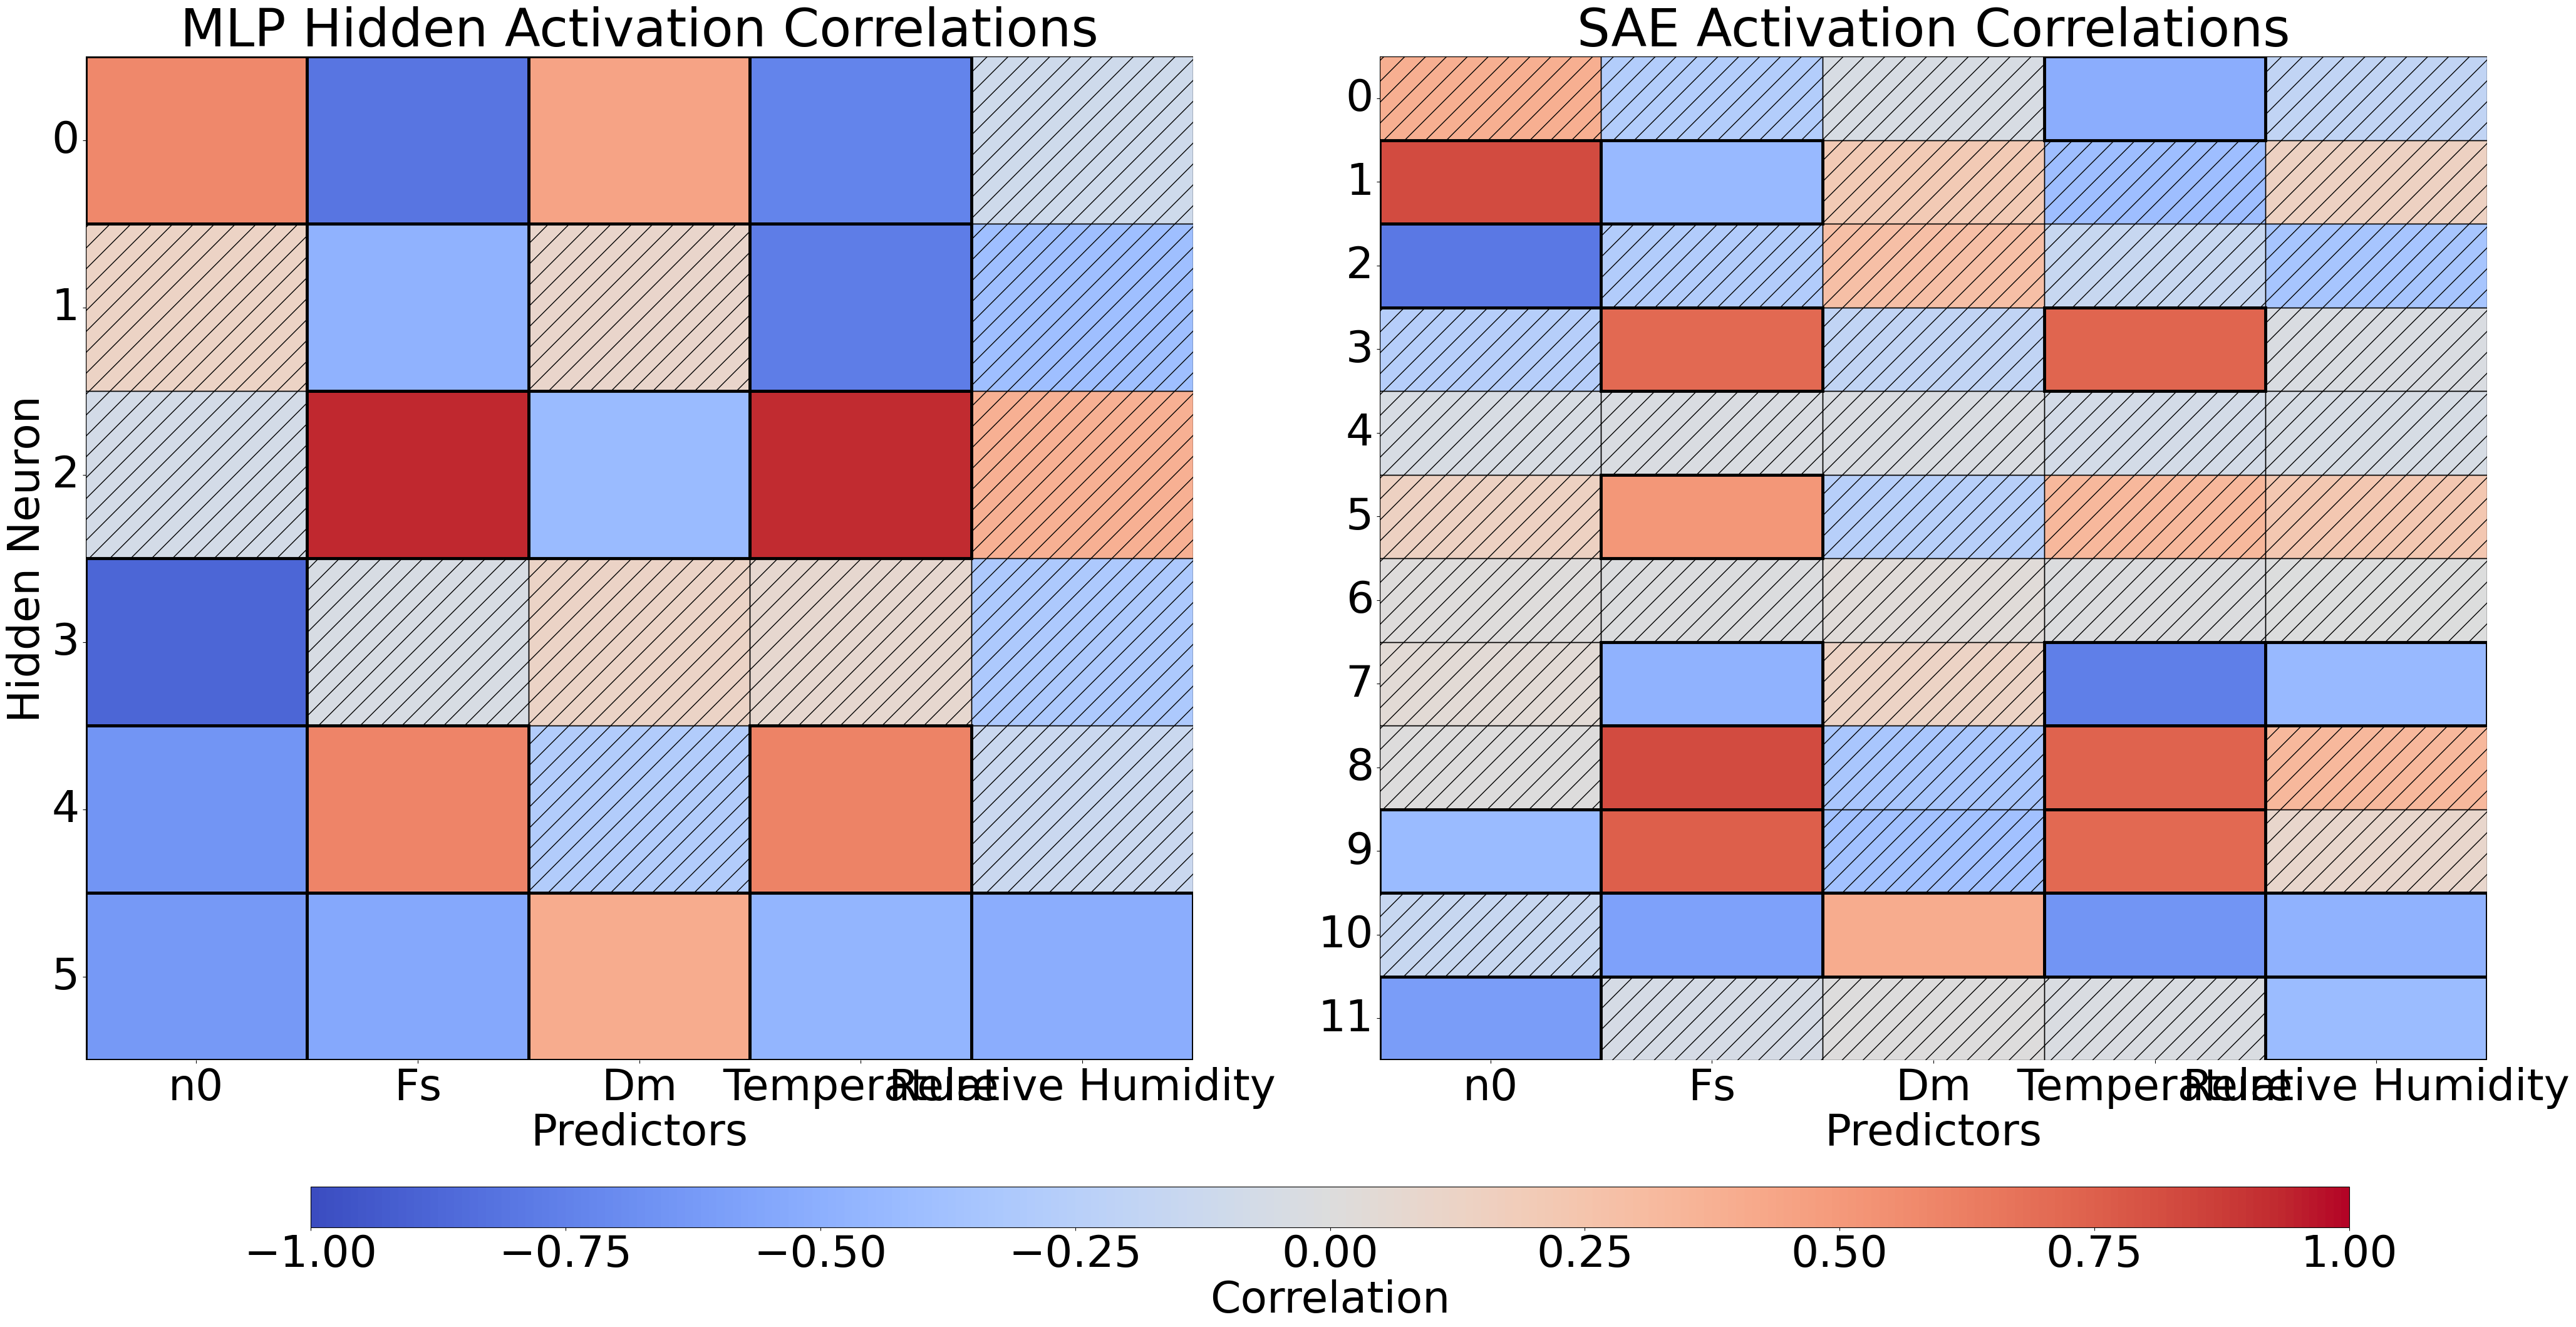

3.0 2.1


In [12]:
### Generate correlation matrices for original MLP and SAE inputs and hidden activations

# Note that a r>0.4 sensitivity threshold is applied here to highlight the
# most sensitive input-activation relationships. Note that this threshold is
# somewhat arbitrary but was selected after testing a variety of values
def plot_mlp_and_sae_correlations(model, activation_model, encoder_model, sae_test_X, predictors):
    hidden_layer = model.layers[0]
    hidden_activation_model = Model(inputs=model.layers[0].input, outputs=model.layers[0].output)
    mlp_hidden_activations = hidden_activation_model.predict(sae_test_X)

    n_hidden_units = mlp_hidden_activations.shape[1]
    n_predictors = len(predictors)
    mlp_corr_matrix = np.zeros((n_hidden_units, n_predictors))

    for i in range(n_hidden_units):
        for j in range(n_predictors):
            r, _ = pearsonr(mlp_hidden_activations[:, i], sae_test_X[:, j])
            mlp_corr_matrix[i, j] = r

    mlp_unit_names = [f"{i}" for i in range(n_hidden_units)]
    mlp_corr_df = pd.DataFrame(mlp_corr_matrix, index=mlp_unit_names, columns=predictors)

    # This is where we use that saved encoder model from earlier
    sae_encoded_activations = encoder_model.predict(mlp_hidden_activations)
    n_sae_units = sae_encoded_activations.shape[1]
    sae_corr_matrix = np.zeros((n_sae_units, n_predictors))

    for i in range(n_sae_units):
        for j in range(n_predictors):
            r, _ = pearsonr(sae_encoded_activations[:, i], sae_test_X[:, j])
            sae_corr_matrix[i, j] = r

    sae_unit_names = [f"{i}" for i in range(n_sae_units)]
    sae_corr_df = pd.DataFrame(sae_corr_matrix, index=sae_unit_names, columns=predictors)

    # Plot the correlation matrices together
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(42, 24))
    vmin, vmax = -1, 1
    fsize = 50

    im1 = sns.heatmap(
        mlp_corr_df,
        ax=axes[0],
        annot=False,
        fmt=".2f",
        cmap='coolwarm',
        vmin=vmin,
        vmax=vmax,
        center=0,
        cbar=False
    )
    axes[0].set_title("MLP Hidden Activation Correlations", fontsize=fsize+10)
    axes[0].set_xlabel("Predictors", fontsize=fsize)
    axes[0].set_ylabel("Hidden Neuron", fontsize=fsize)
    axes[0].set_yticklabels(axes[0].get_ymajorticklabels(), rotation=0, fontsize=fsize)
    axes[0].set_xticklabels(axes[0].get_xmajorticklabels(), rotation=0, fontsize=fsize)

    im2 = sns.heatmap(
        sae_corr_df,
        ax=axes[1],
        annot=False,
        fmt=".2f",
        cmap='coolwarm',
        vmin=vmin,
        vmax=vmax,
        center=0,
        cbar=False
    )
    axes[1].set_title("SAE Activation Correlations", fontsize=fsize+10)
    axes[1].set_xlabel("Predictors", fontsize=fsize)
    axes[1].set_ylabel("")
    axes[1].set_yticklabels(axes[1].get_ymajorticklabels(), rotation=0, fontsize=fsize)
    axes[1].set_xticklabels(axes[1].get_xmajorticklabels(), rotation=0, fontsize=fsize)

    for i in range(n_hidden_units):
        for j in range(n_predictors):
            val = mlp_corr_df.iloc[i, j]
            if -0.4 <= val <= 0.4:
                rect = patches.Rectangle((j, i), 1, 1, fill=False, hatch='/')
                axes[0].add_patch(rect)
            else:
                rect = patches.Rectangle((j, i), 1, 1, fill=False, linewidth=3.5)
                axes[0].add_patch(rect)

    for i in range(n_sae_units):
        for j in range(n_predictors):
            val = sae_corr_df.iloc[i, j]
            if -0.4 <= val <= 0.4 or math.isnan(val):
                rect = patches.Rectangle((j, i), 1, 1, fill=False, hatch='/')
                axes[1].add_patch(rect)
            else:
                rect = patches.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', linewidth=3.5)
                axes[1].add_patch(rect)

    cbar = fig.colorbar(
        im1.collections[0],
        ax=axes,
        orientation="horizontal",
        fraction= 0.05,
        pad=-0.25,
        aspect=50
    )

    cbar.set_label("Correlation", fontsize=fsize)
    cbar.ax.tick_params(labelsize=fsize)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    return mlp_corr_df, sae_corr_df, mlp_hidden_activations, sae_encoded_activations

# mlp_corr_df, sae_corr_df, mlp_hidden_activations, sae_encoded_activations = plot_mlp_and_sae_correlations(model, activation_model, encoder_model, sae_test_X, ['n$_0$', 'Fs', 'D$_m$', 'T', 'RH'])
mlp_corr_df, sae_corr_df, mlp_hidden_activations, sae_encoded_activations = plot_mlp_and_sae_correlations(model, activation_model, encoder_model, sae_test_X, predictors)
sparse_activations = sae_encoded_activations

# Check to see how the mean number of input-activation sensitivities change per
# hidden layer neuron in the MLP vs. SAE
above_or_below_threshold_counts = mlp_corr_df.gt(0.4).sum(axis=1) + mlp_corr_df.lt(-0.4).sum(axis=1)
filtered_counts = above_or_below_threshold_counts[above_or_below_threshold_counts > 0]
mlp_avg = filtered_counts.mean()
above_or_below_threshold_counts = sae_corr_df.gt(0.4).sum(axis=1) + sae_corr_df.lt(-0.4).sum(axis=1)
filtered_counts = above_or_below_threshold_counts[above_or_below_threshold_counts > 0]
sae_avg = filtered_counts.mean()

print(mlp_avg, sae_avg)

In [13]:
### Run a UMAP dimensionality reduction on the data for visualization
### (more details in UMAP: https://umap-learn.readthedocs.io/en/latest/)

umap_reducer = umap.UMAP(n_components=2, random_state=STATE, min_dist=0.2)
umap_embedding = umap_reducer.fit_transform(sae_test_X)

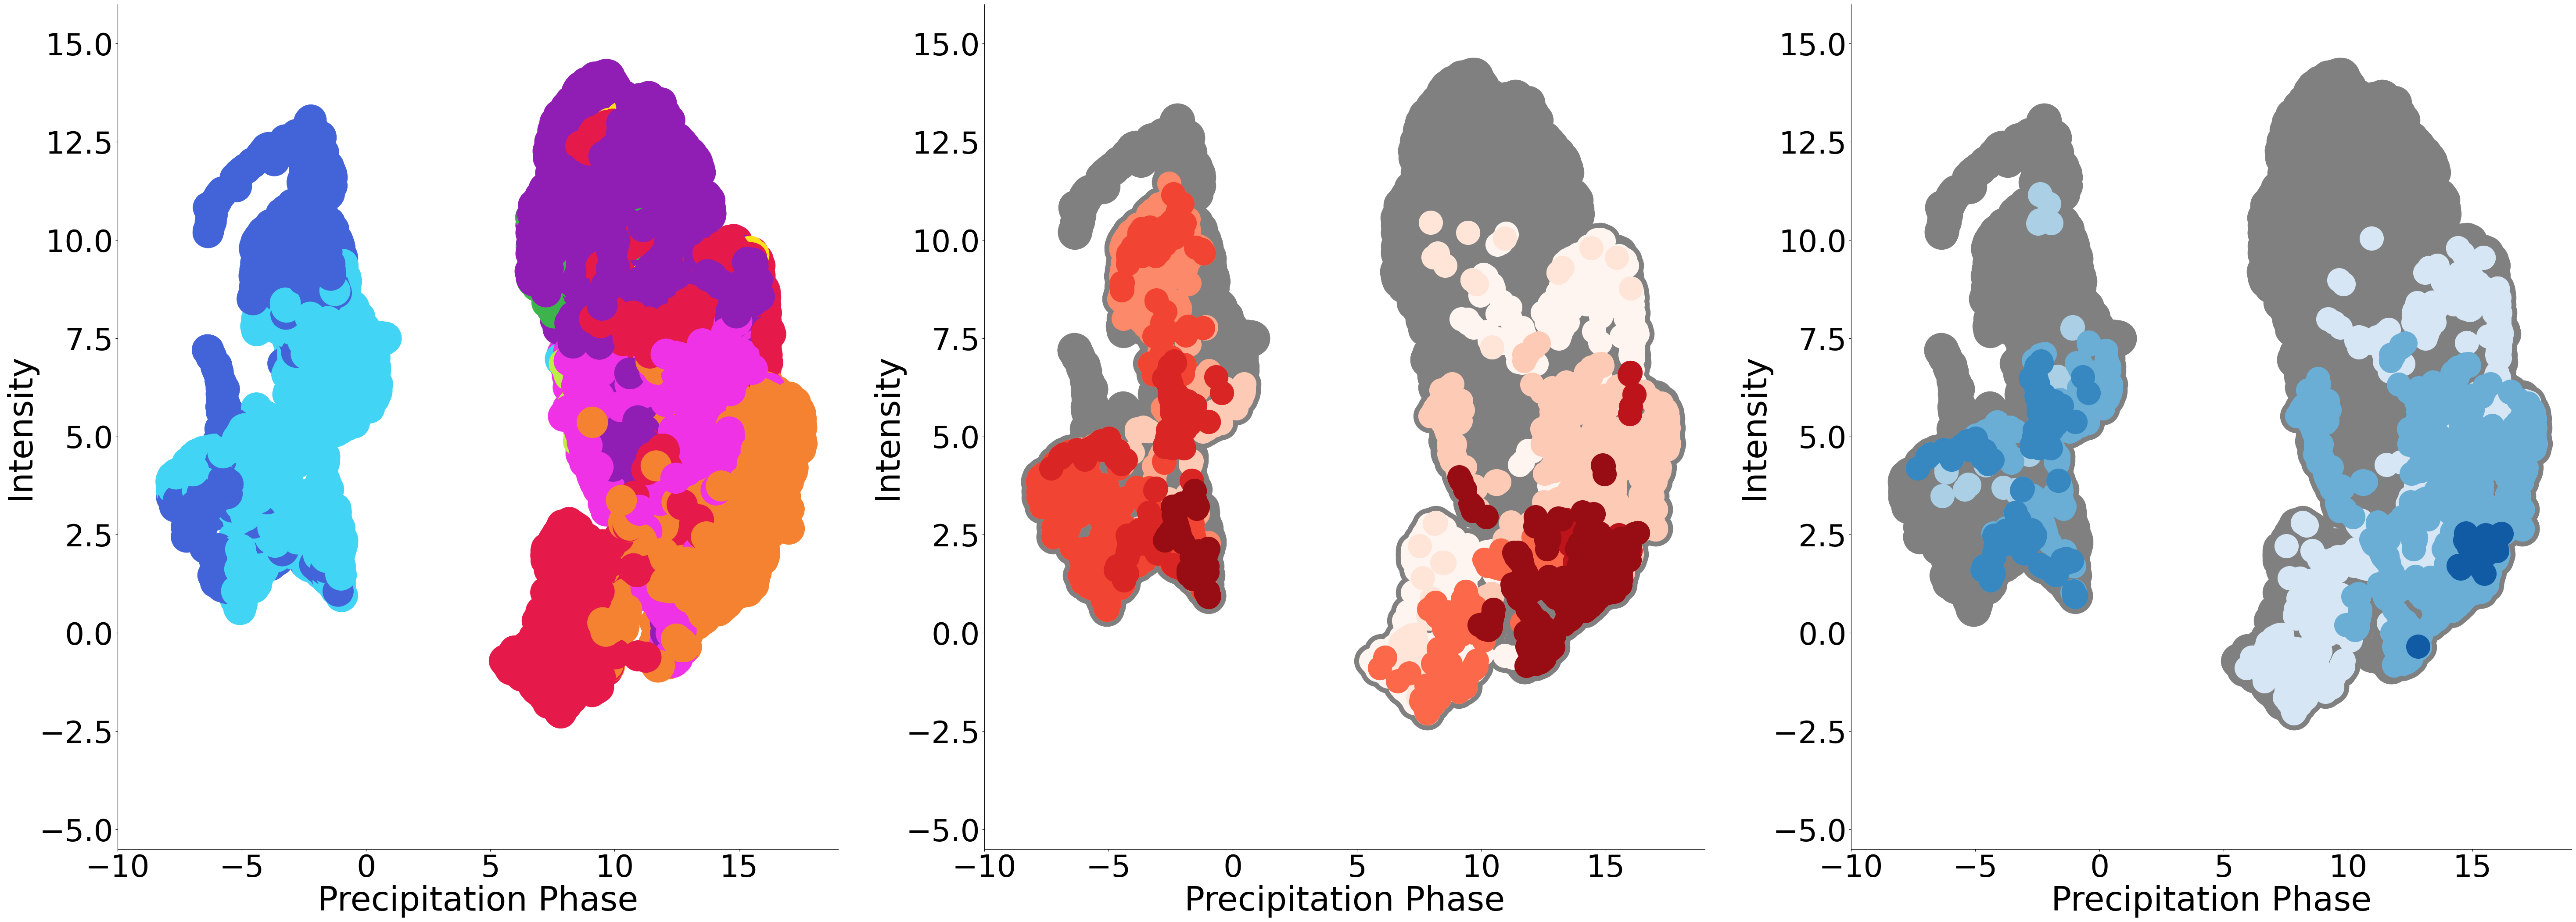

In [14]:
### Plot the data and active hidden neurons in UMAP coordinate space

def plot_umap_space():
    plt.rcParams.update({'font.size': 50})
    class_cmap = ListedColormap(colors)

    fig, axes = plt.subplots(1, 3, figsize=(60, 25))

    ax_left = axes[0]
    ax_middle = axes[1]
    ax_right = axes[2]

    scatter = ax_left.scatter(
        umap_embedding[:, 0], umap_embedding[:, 1],
        facecolors=[colors[y] for y in sae_test_y],
        s=2500, alpha=1
    )

    handles = []
    cluster_names = [
        "Heavy R-M", "Heavy Rainfall", "Light R-M", "Drizzle",
        "Heavy Mixed", "Heavy S-M", "Heavy Snowfall", "Light Mixed", "Light Snowfall"
    ]
    for cls_idx, c_label in enumerate(cluster_names):
        handles.append(mlines.Line2D(
            [], [],
            marker='o',
            markerfacecolor=colors[cls_idx],
            markeredgecolor=colors[cls_idx],
            markeredgewidth=2,
            linestyle='None',
            markersize=50,
            label=c_label
        ))

    ax_left.set_xlabel('Precipitation Phase', fontsize=55)
    ax_left.set_ylabel('Intensity', fontsize=55)
    ax_left.grid(False)
    sns.despine(ax=ax_left)
    ax_left.set_xlim((-10, 19))
    ax_left.set_ylim((-5.5, 16))

    def highlight_mask_sae(unit_idx, sae_threshold_percentile, cond_dict):
        mask = np.ones(sae_test_X.shape[0], dtype=bool)

        for p_idx, (comp, perc) in cond_dict.items():
            threshold = np.percentile(sae_test_X[:, p_idx], perc)
            if comp == "gt":
                mask &= (sae_test_X[:, p_idx] > threshold)
            elif comp == "lt":
                mask &= (sae_test_X[:, p_idx] < threshold)

        sae_threshold = np.percentile(sparse_activations[:, unit_idx], sae_threshold_percentile)
        mask &= (sparse_activations[:, unit_idx] > sae_threshold)

        return mask

    corr_threshold = 0.4
    high_percentile = 80
    low_percentile = 20
    sae_activation_percentile = 80

    sae_cmap = plt.cm.get_cmap('Reds')

    drawn_units_count_sae = 0
    max_units_to_show = 10

    ax_middle.scatter(
        umap_embedding[:, 0], umap_embedding[:, 1], color='gray', s=3000, alpha=1
    )
    for unit_idx in range(sae_corr_df.shape[0]):
        row_corrs = sae_corr_df.iloc[unit_idx].values
        strong_indices = np.where(np.abs(row_corrs) > corr_threshold)[0]
        if len(strong_indices) == 0:
            continue

        cond_dict = {}
        for p_idx in strong_indices:
            corr_value = row_corrs[p_idx]
            if corr_value > corr_threshold:
                cond_dict[p_idx] = ("gt", high_percentile)
            else:
                cond_dict[p_idx] = ("lt", low_percentile)

        mask = highlight_mask_sae(
            unit_idx=unit_idx,
            sae_threshold_percentile=sae_activation_percentile,
            cond_dict=cond_dict
        )

        if np.any(mask):
            if drawn_units_count_sae < max_units_to_show:
                color_to_use = sae_cmap(drawn_units_count_sae / max_units_to_show)

                ax_middle.scatter(
                    umap_embedding[mask, 0], umap_embedding[mask, 1],
                    c=[color_to_use], s=1500, alpha=1,
                    label=f'Unit {unit_idx} \n({", ".join([predictors[i] for i in strong_indices])})'
                )
                drawn_units_count_sae += 1

    ax_middle.set_xlabel('Precipitation Phase', fontsize=55)
    ax_middle.set_ylabel('Intensity', fontsize=55)
    ax_middle.grid(False)
    sns.despine(ax=ax_middle)
    ax_middle.set_xlim((-10, 19))
    ax_middle.set_ylim((-5.5, 16))

    def highlight_mask_mlp(unit_idx, mlp_acts, mlp_threshold_percentile, cond_dict):
        mask = np.ones(sae_test_X.shape[0], dtype=bool)

        for p_idx, (comp, perc) in cond_dict.items():
            threshold = np.percentile(sae_test_X[:, p_idx], perc)
            if comp == "gt":
                mask &= (sae_test_X[:, p_idx] > threshold)
            elif comp == "lt":
                mask &= (sae_test_X[:, p_idx] < threshold)

        mlp_threshold = np.percentile(mlp_acts[:, unit_idx], mlp_threshold_percentile)
        mask &= (mlp_acts[:, unit_idx] > mlp_threshold)

        return mask

    mlp_corr_threshold = 0.4
    mlp_high_percentile = 80
    mlp_low_percentile = 20
    mlp_activation_percentile = 80

    mlp_cmap = plt.cm.get_cmap('Blues')

    drawn_units_count_mlp = 0
    max_units_to_show_mlp = 6

    ax_right.scatter(
        umap_embedding[:, 0], umap_embedding[:, 1], color='gray', s=3000, alpha=1
    )

    for unit_idx in range(mlp_corr_df.shape[0]):
        row_corrs = mlp_corr_df.iloc[unit_idx].values
        strong_indices = np.where(np.abs(row_corrs) > mlp_corr_threshold)[0]
        if len(strong_indices) == 0:
            continue

        cond_dict = {}
        for p_idx in strong_indices:
            corr_value = row_corrs[p_idx]
            if corr_value > mlp_corr_threshold:
                cond_dict[p_idx] = ("gt", mlp_high_percentile)
            else:
                cond_dict[p_idx] = ("lt", mlp_low_percentile)

        mask = highlight_mask_mlp(
            unit_idx=unit_idx,
            mlp_acts=mlp_hidden_activations,
            mlp_threshold_percentile=mlp_activation_percentile,
            cond_dict=cond_dict
        )

        if np.any(mask):
            if drawn_units_count_mlp < max_units_to_show_mlp:
                color_to_use = mlp_cmap(drawn_units_count_mlp / max_units_to_show_mlp)

                ax_right.scatter(
                    umap_embedding[mask, 0], umap_embedding[mask, 1],
                    c=[color_to_use], s=1500, alpha=1,
                    label=f'Unit {unit_idx}\n({", ".join([predictors[i] for i in strong_indices])})'
                )
                drawn_units_count_mlp += 1

    ax_right.set_xlabel('Precipitation Phase', fontsize=55)
    ax_right.set_ylabel('Intensity', fontsize=55)
    ax_right.grid(False)
    sns.despine(ax=ax_right)

    ax_right.set_xlim((-10, 19))
    ax_right.set_ylim((-5.5, 16))

    handles_left, labels_left = ax_left.get_legend_handles_labels()
    handles_middle, labels_middle = ax_middle.get_legend_handles_labels()
    handles_right, labels_right = ax_right.get_legend_handles_labels()

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()

plot_umap_space()

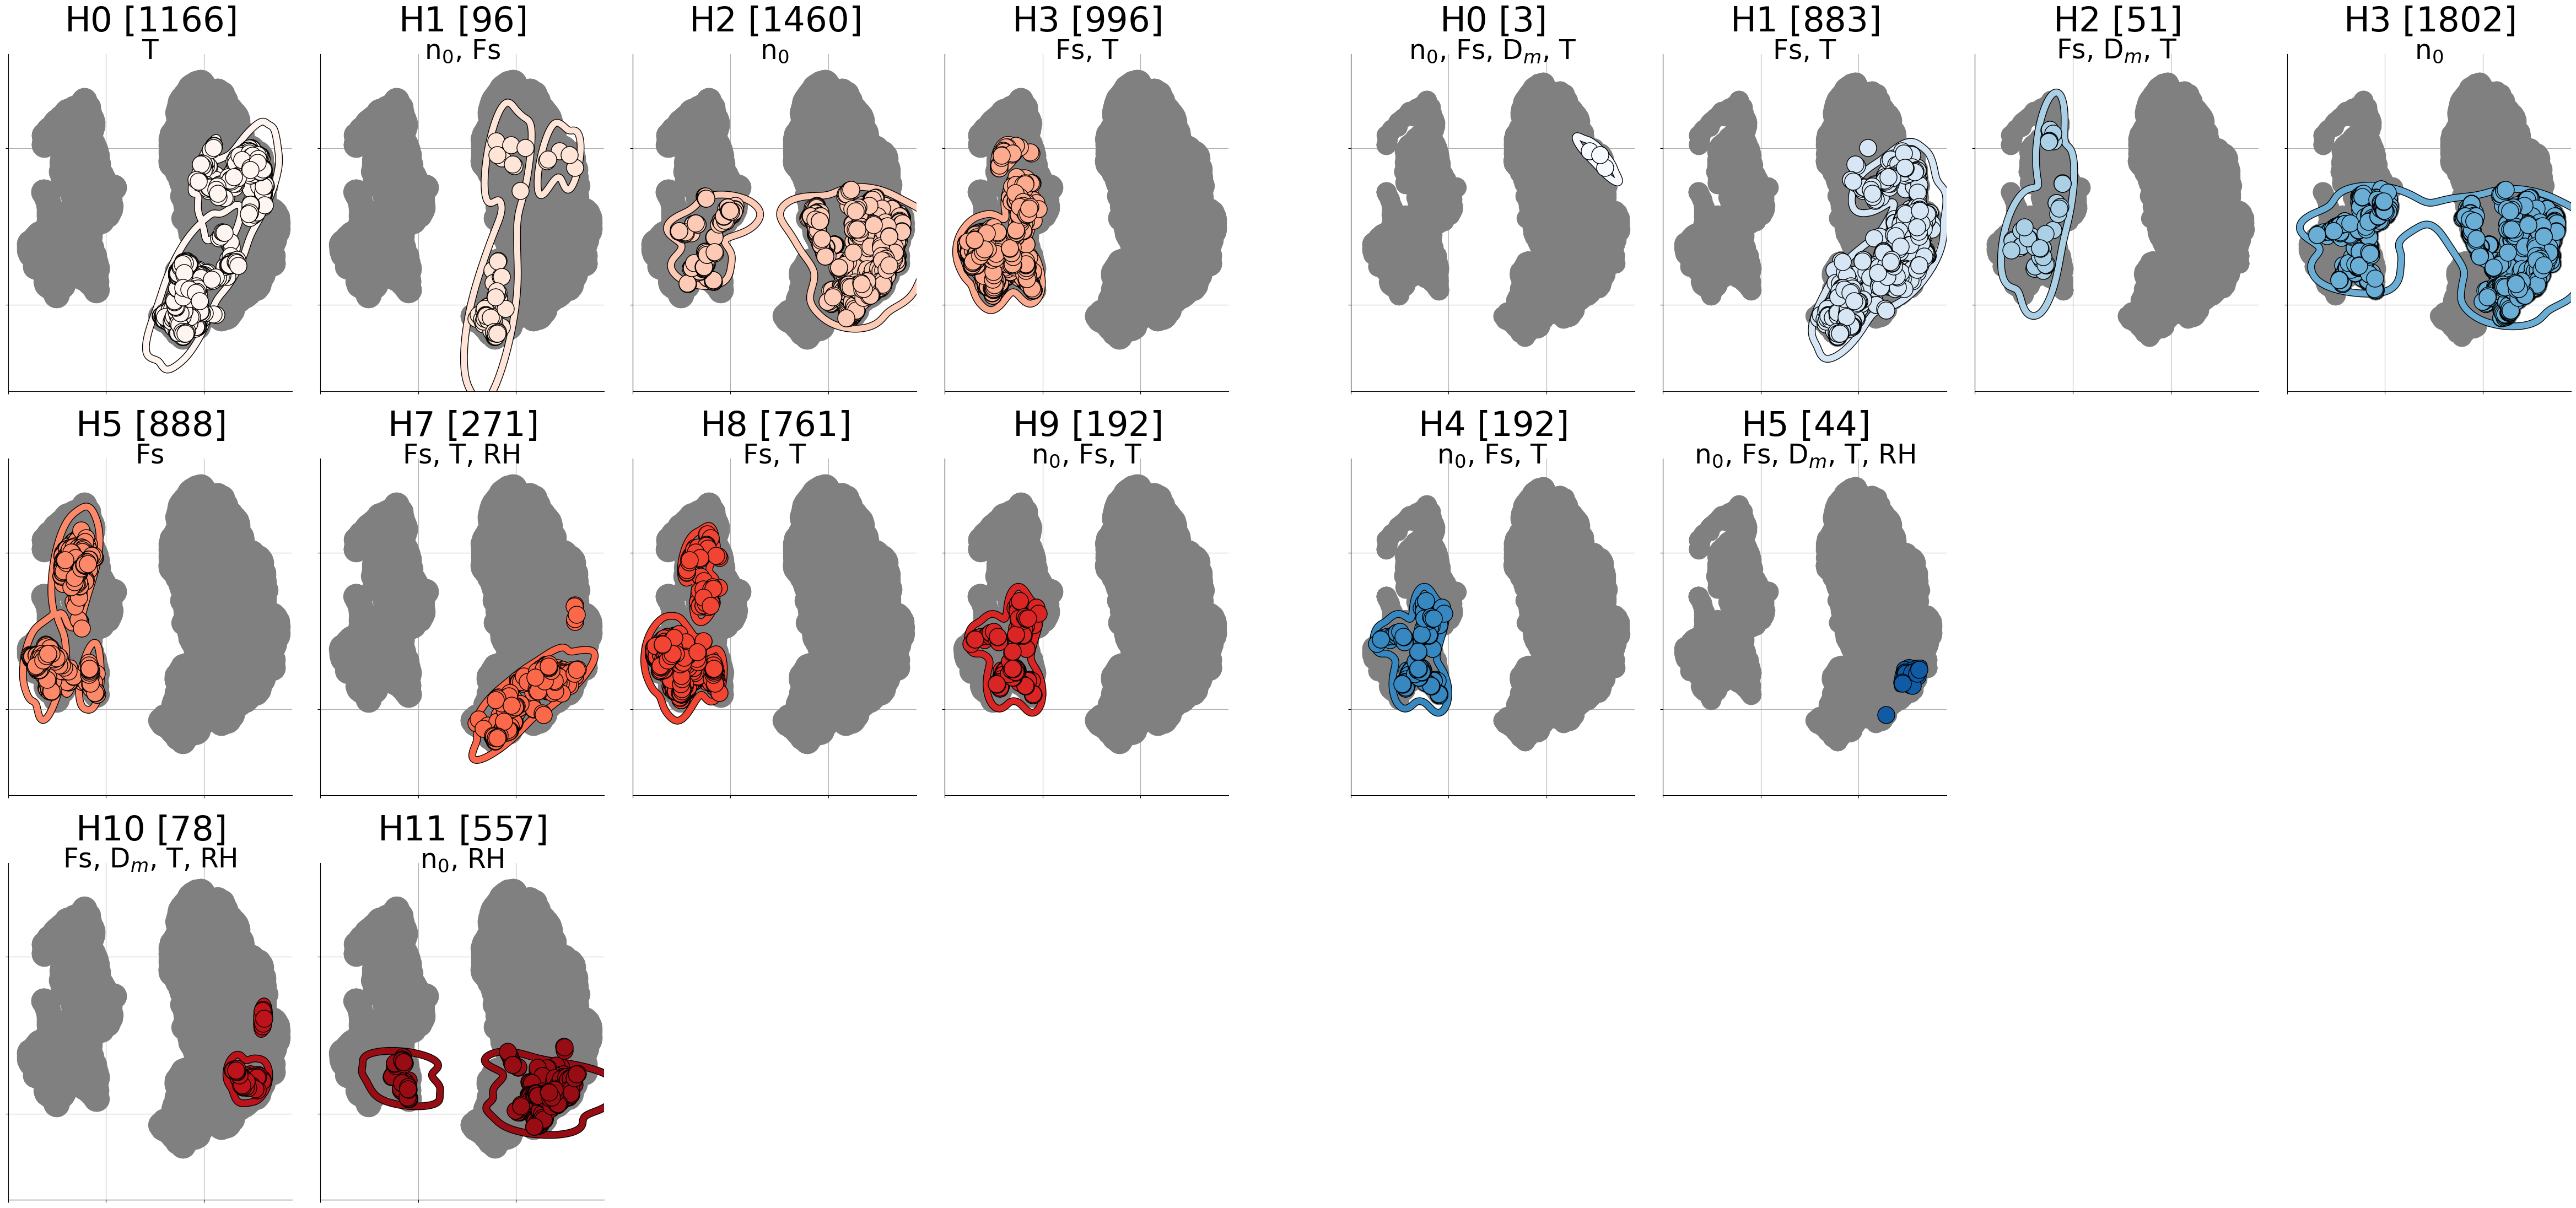

In [15]:
### Plot individual hidden layer activations in UMAP space to better visualize
### the structure of these sensitive neurons wrt. the observed physical classes

def plot_individual_activations():
    plt.rcParams.update({'font.size': 45})
    fig = plt.figure(figsize=(60, 27))
    gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.1)

    gs_sae = gs[0, 0].subgridspec(3, 4, wspace=0.1, hspace=0.2)
    sae_axes = [fig.add_subplot(gs_sae[i, j]) for i in range(3) for j in range(4)]

    gs_mlp = gs[0, 1].subgridspec(3, 4, wspace=0.1, hspace=0.2)
    mlp_axes = [fig.add_subplot(gs_mlp[i, j]) for i in range(3) for j in range(4)]

    corr_threshold = 0.4
    high_percentile = 80
    low_percentile = 20
    sae_activation_percentile = 80

    mlp_corr_threshold = 0.4
    mlp_high_percentile = 80
    mlp_low_percentile = 20
    mlp_activation_percentile = 80

    sae_cmap = plt.cm.get_cmap('Reds')
    mlp_cmap = plt.cm.get_cmap('Blues')

    def highlight_mask_sae(unit_idx, sae_threshold_percentile, cond_dict):
        mask = np.ones(sae_test_X.shape[0], dtype=bool)

        for p_idx, (comp, perc) in cond_dict.items():
            threshold = np.percentile(sae_test_X[:, p_idx], perc)
            if comp == "gt":
                mask &= (sae_test_X[:, p_idx] > threshold)
            elif comp == "lt":
                mask &= (sae_test_X[:, p_idx] < threshold)

        sae_threshold = np.percentile(sparse_activations[:, unit_idx], sae_threshold_percentile)
        mask &= (sparse_activations[:, unit_idx] > sae_threshold)
        return mask

    def highlight_mask_mlp(unit_idx, mlp_acts, mlp_threshold_percentile, cond_dict):

        mask = np.ones(sae_test_X.shape[0], dtype=bool)

        for p_idx, (comp, perc) in cond_dict.items():
            threshold = np.percentile(sae_test_X[:, p_idx], perc)
            if comp == "gt":
                mask &= (sae_test_X[:, p_idx] > threshold)
            elif comp == "lt":
                mask &= (sae_test_X[:, p_idx] < threshold)

        mlp_threshold = np.percentile(mlp_acts[:, unit_idx], mlp_threshold_percentile)
        mask &= (mlp_acts[:, unit_idx] > mlp_threshold)

        return mask

    sae_unit_indices = []
    for unit_idx in range(sae_corr_df.shape[0]):
        row_corrs = sae_corr_df.iloc[unit_idx].values
        if np.any(np.abs(row_corrs) > corr_threshold):
            sae_unit_indices.append(unit_idx)

    sae_unit_indices = sae_unit_indices[:10]

    for i, unit_idx in enumerate(sae_unit_indices):
        ax_sae = sae_axes[i]

        ax_sae.scatter(
            umap_embedding[:, 0],
            umap_embedding[:, 1],
            color='gray',
            s=1000,
            alpha=1,
            zorder=999
        )

        row_corrs = sae_corr_df.iloc[unit_idx].values
        strong_indices = np.where(np.abs(row_corrs) > corr_threshold)[0]

        highlight_count = 0
        strong_col_names = []
        replacements = {
            "n0": "n$_0$",
            "Dm": "D$_m$",
            "Temperature": "T",
            "Relative Humidity": "RH",
        }

        if len(strong_indices) > 0:
            strong_col_names_t = sae_corr_df.columns[strong_indices].tolist()

            strong_col_names = -1
            for old, new in replacements.items():
                strong_col_names = [replacements.get(item, item) for item in strong_col_names_t]

            cond_dict = {}
            for p_idx in strong_indices:
                corr_value = row_corrs[p_idx]
                if corr_value > corr_threshold:
                    cond_dict[p_idx] = ("gt", high_percentile)
                else:
                    cond_dict[p_idx] = ("lt", low_percentile)

            mask = highlight_mask_sae(
                unit_idx=unit_idx,
                sae_threshold_percentile=sae_activation_percentile,
                cond_dict=cond_dict
            )

            highlight_count = np.sum(mask)

            if highlight_count > 0:
                color_to_use = sae_cmap(float(i) / len(sae_unit_indices))

                sns.kdeplot(
                    x=umap_embedding[mask, 0],
                    y=umap_embedding[mask, 1],
                    ax=ax_sae,
                    color='black',
                    fill=False,
                    levels=2,
                    linewidths=10,
                    zorder=1000
                )

                sns.kdeplot(
                    x=umap_embedding[mask, 0],
                    y=umap_embedding[mask, 1],
                    ax=ax_sae,
                    color=color_to_use,
                    fill=False,
                    levels=2,
                    linewidths=8,
                    zorder=1001
                )

                ax_sae.scatter(
                    umap_embedding[mask, 0],
                    umap_embedding[mask, 1],
                    c=[color_to_use],
                    s=500,
                    edgecolor='black',
                    alpha=1,
                    label=f'Unit {unit_idx}',
                    zorder=1002
                )

        main_title = f"H{unit_idx} [${highlight_count}$]"
        ax_sae.set_title(main_title, fontsize=45, pad=30)

        if len(strong_col_names) > 0:
            colnames_str = ", ".join(strong_col_names)
            ax_sae.text(
                0.5, 0.97,
                colnames_str,
                transform=ax_sae.transAxes,
                ha='center',
                va='bottom',
                fontsize=35
            )

        ax_sae.set_xlim((-10, 19))
        ax_sae.set_ylim((-5.5, 16))
        ax_sae.grid(True, zorder=998)
        ax_sae.tick_params(axis='x', labelbottom=False)
        ax_sae.tick_params(axis='y', labelleft=False)
        sns.despine(ax=ax_sae)

    for j in range(len(sae_unit_indices), 12):
        sae_axes[j].axis("off")


    mlp_unit_indices = []
    for unit_idx in range(mlp_corr_df.shape[0]):
        row_corrs = mlp_corr_df.iloc[unit_idx].values
        if np.any(np.abs(row_corrs) > mlp_corr_threshold):
            mlp_unit_indices.append(unit_idx)

    mlp_unit_indices = mlp_unit_indices[:9]

    for i, unit_idx in enumerate(mlp_unit_indices):
        ax_mlp = mlp_axes[i]

        ax_mlp.scatter(
            umap_embedding[:, 0],
            umap_embedding[:, 1],
            color='gray',
            s=600,
            alpha=1,
            zorder=999
        )

        row_corrs = mlp_corr_df.iloc[unit_idx].values
        strong_indices = np.where(np.abs(row_corrs) > mlp_corr_threshold)[0]

        highlight_count = 0
        strong_col_names = []

        if len(strong_indices) > 0:
            strong_col_names_t = mlp_corr_df.columns[strong_indices].tolist()

            strong_col_names = -1
            for old, new in replacements.items():
                strong_col_names = [replacements.get(item, item) for item in strong_col_names_t]

            cond_dict = {}
            for p_idx in strong_indices:
                corr_value = row_corrs[p_idx]
                if corr_value > mlp_corr_threshold:
                    cond_dict[p_idx] = ("gt", mlp_high_percentile)
                else:
                    cond_dict[p_idx] = ("lt", mlp_low_percentile)

            mask = highlight_mask_mlp(
                unit_idx=unit_idx,
                mlp_acts=mlp_hidden_activations,
                mlp_threshold_percentile=mlp_activation_percentile,
                cond_dict=cond_dict
            )

            highlight_count = np.sum(mask)

            if highlight_count > 0:
                color_to_use = mlp_cmap(float(i) / len(mlp_unit_indices))

                sns.kdeplot(
                    x=umap_embedding[mask, 0],
                    y=umap_embedding[mask, 1],
                    ax=ax_mlp,
                    color='black',
                    fill=False,
                    levels=2,
                    linewidths=10,
                    zorder=1000
                )

                sns.kdeplot(
                    x=umap_embedding[mask, 0],
                    y=umap_embedding[mask, 1],
                    ax=ax_mlp,
                    color=color_to_use,
                    fill=False,
                    levels=2,
                    linewidths=8,
                    zorder=1001
                )

                ax_mlp.scatter(
                    umap_embedding[mask, 0],
                    umap_embedding[mask, 1],
                    c=[color_to_use],
                    edgecolor='black',
                    s=500,
                    alpha=1,
                    label=f'Unit {unit_idx}',
                    zorder=1002
                )

        main_title = f"H{unit_idx} [${highlight_count}$]"
        ax_mlp.set_title(main_title, fontsize=45, pad=30)

        if len(strong_col_names) > 0:
            colnames_str = ", ".join(strong_col_names)
            ax_mlp.text(
                0.5, 0.97,
                colnames_str,
                transform=ax_mlp.transAxes,
                ha='center',
                va='bottom',
                fontsize=35
            )

        ax_mlp.set_xlim((-10, 19))
        ax_mlp.set_ylim((-5.5, 16))
        ax_mlp.tick_params(axis='x', labelbottom=False)
        ax_mlp.tick_params(axis='y', labelleft=False)
        ax_mlp.grid(True, zorder=998)
        sns.despine(ax=ax_mlp)

    for j in range(len(mlp_unit_indices), 12):
        mlp_axes[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_individual_activations()

In [16]:
print("Classifier notebook execution was successful!")

Classifier notebook execution was successful!
